# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

Please make sure if you are running this notebook in the workspace that you have chosen GPU rather than CPU mode.

In [1]:
#imports Pytorch Tutorial

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive 

# for Classifier 
from torch import nn

from collections import OrderedDict

# for image processing
from PIL import Image

# for prediction
import torch.nn.functional as F
# sanity check
from matplotlib.ticker import FormatStrFormatter

# New trial
import seaborn as sns
import copy

Notes for the reviewer:
1. There was a problem in regards to the firstly trained network, which was RESNET with fc layer, after not beeing able to overcome this situation and after realising in the second part of the project that at least two networks need to be trained, and I yet do not know another network with fc layer, I rewrote the code for networks with classifier layers, therefore please disregard outcommented cells of the notebook.

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])


# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
validation_data = datasets.ImageFolder(valid_dir, transform=validation_transforms)
test_data = datasets.ImageFolder(test_dir ,transform = test_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
vloader = torch.utils.data.DataLoader(validation_data, batch_size =32,shuffle = True)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 20, shuffle = True)

class_names = train_data.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
# RESNET with FC layer
# TODO: Define your transforms for the training, validation, and testing sets
'''
data_transforms = {
'train': transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])
                            ]),
'valid': transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])
                          ]),
'test': transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])
                           ]),
}
# TODO: Load the datasets with ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid', 'test']}
'''
'''test_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.CenterCrop(224),
 #in general wrong transformations     transforms.RandomResizedCrop(100),
   because its test set                transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])'''

'''train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/val', transform=valid_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)'''

'''
# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'valid', 'test']}
'''
'''trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)'''
'''
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
'''

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

In [6]:
# RESNET with fc layer
# Visualization according to pytorch tutorial
'''
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
'''

NameError: name 'dataloaders' is not defined

In [6]:
# RESNET with Fc layer
'''
#Pytorch Tutorial general Function for Training 
def train_model(model_conv, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model_conv.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model_conv.train()  # Set model to training mode
            else:
                model_conv.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model_conv(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model_conv.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: {:4f}'.format(best_acc))

    # load best model weights
    model_conv.load_state_dict(best_model_wts)
    return model_conv
'''

"\n#Pytorch Tutorial general Function for Training \ndef train_model(model_conv, criterion, optimizer, scheduler, num_epochs=25):\n    since = time.time()\n\n    best_model_wts = copy.deepcopy(model_conv.state_dict())\n    best_acc = 0.0\n\n    for epoch in range(num_epochs):\n        print('Epoch {}/{}'.format(epoch, num_epochs - 1))\n        print('-' * 10)\n\n        # Each epoch has a training and validation phase\n        for phase in ['train', 'valid']:\n            if phase == 'train':\n                scheduler.step()\n                model_conv.train()  # Set model to training mode\n            else:\n                model_conv.eval()   # Set model to evaluate mode\n\n            running_loss = 0.0\n            running_corrects = 0\n\n            # Iterate over data.\n            for inputs, labels in dataloaders[phase]:\n                inputs = inputs.to(device)\n                labels = labels.to(device)\n\n                # zero the parameter gradients\n                opt

In [5]:
# RESNET with Fc layer
#Pytorch generic function for visualizing batches
'''
def visualize_model(model_conv, num_images=6):
    was_training = model_conv.training
    model_conv.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            
            inputs = inputs.to(cuda) # here change: device to cuda
            labels = labels.to(cuda) # here change: device to cuda

            outputs = model_conv.forward(inputs) # here .forward added
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model_conv.train(mode=was_training)
                    return
        model_conv.train(mode=was_training)
'''

In [5]:
# Defining Classifier Networks
structures = {"vgg16":25088,
              "densenet121" : 1024,
              "alexnet" : 9216 }

In [6]:
# Defining Classifier Networks
def nn_setup(structure='vgg16',dropout=0.5, hidden_layer1 = 120,lr = 0.001):
    
    
    if structure == 'vgg16':
        model_conv = models.vgg16(pretrained=True)        
    elif structure == 'alexnet':
        model_conv = models.alexnet(pretrained = True)
    elif structure == 'densenet121':
        model_conv = models.densenet121(pretrained=True)
    
    for param in model_conv.parameters():
        param.requires_grad = False
    
    else:
        print("Exercise only trains and accepts Classifier-Networks vgg16, alexnet, and densenet121.")
        
    
        
    

    from collections import OrderedDict
    classifier = nn.Sequential(OrderedDict([
        ('dropout',nn.Dropout(dropout)),
        ('inputs', nn.Linear(structures[structure], hidden_layer1)),
        ('relu1', nn.ReLU()),
        ('hidden_layer1', nn.Linear(hidden_layer1, 90)),
        ('relu2',nn.ReLU()),
        ('hidden_layer2',nn.Linear(90,80)),
        ('relu3',nn.ReLU()),
        ('hidden_layer3',nn.Linear(80,102)),
        ('output', nn.LogSoftmax(dim=1))
                          ]))
        
        
    model_conv.classifier = classifier
    criterion = nn.NLLLoss()
    optimizer_conv = optim.Adam(model_conv.classifier.parameters(), lr )
    model_conv.cuda()
        
    return model_conv , optimizer_conv ,criterion 

    

model_conv,optimizer_conv,criterion = nn_setup(structure='densenet121')

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:01<00:00, 25436599.16it/s]


Exercise only trains and accepts Classifier-Networks vgg16, alexnet, and densenet121.


In [8]:
nn_setup('densenet121')

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


Exercise only trains and accepts Classifier-Networks vgg16, alexnet, and densenet121.


(DenseNet(
   (features): Sequential(
     (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
     (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu0): ReLU(inplace)
     (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
     (denseblock1): _DenseBlock(
       (denselayer1): _DenseLayer(
         (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu1): ReLU(inplace)
         (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
         (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu2): ReLU(inplace)
         (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       )
       (denselayer2): _DenseLayer(
         (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (r

In [11]:
# RESNET with Fc Layer
'''#

#ConvNet as fixed feature extractor
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False


model_conv.dropout = nn.Dropout(p=0.2)
model_conv
# Get number of parameters going in to the last layer. we need this to change the final layer. 
num_final_in = model_conv.fc.in_features

# The final layer of the model is model.fc so we can basically just overwrite it 
#to have the output = number of classes we need. Say, 102 classes.
NUM_CLASSES = 102
model_conv.fc = nn.Linear(512, NUM_CLASSES)###[512, 256])# Parameters of newly constructed modules have requires_grad=True by default

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

'''

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:02<00:00, 19535872.32it/s]


In [7]:
print(model_conv)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [ ]:
# Training Classifier Networks
# Putting the above into functions, so they can be used later

epochs = 11
print_every = 5
steps = 0
loss_show=[]

# change to cuda
model_conv.to('cuda')

for e in range(epochs):
    running_loss = 0
    for ii, (inputs, labels) in enumerate(trainloader):
        steps += 1
        
        inputs,labels = inputs.to('cuda'), labels.to('cuda')
        
        optimizer_conv.zero_grad()
        
        # Forward and backward passes
        outputs = model_conv.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_conv.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            model_conv.eval()
            vlost = 0
            accuracy=0
            
            for ii, (inputs2,labels2) in enumerate(vloader):
                optimizer_conv.zero_grad()
                
                inputs2, labels2 = inputs2.to('cuda:0') , labels2.to('cuda:0')
                model_conv.to('cuda:0')
                with torch.no_grad():    
                    outputs = model_conv.forward(inputs2)
                    vlost = criterion(outputs,labels2)
                    ps = torch.exp(outputs).data
                    equality = (labels2.data == ps.max(1)[1])
                    accuracy += equality.type_as(torch.FloatTensor()).mean()
                    
            vlost = vlost / len(vloader)
            accuracy = accuracy /len(vloader)
            
                    
            
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every),
                  "Validation Lost {:.4f}".format(vlost),
                   "Accuracy: {:.4f}".format(accuracy))
            
            
            running_loss = 0

Epoch: 1/11...  Loss: 4.6281 Validation Lost 0.1769 Accuracy: 0.0060
Epoch: 1/11...  Loss: 4.6086 Validation Lost 0.1774 Accuracy: 0.0478
Epoch: 1/11...  Loss: 4.5875 Validation Lost 0.1750 Accuracy: 0.0418
Epoch: 1/11...  Loss: 4.5628 Validation Lost 0.1774 Accuracy: 0.0337
Epoch: 1/11...  Loss: 4.5051 Validation Lost 0.1697 Accuracy: 0.0337
Epoch: 1/11...  Loss: 4.4874 Validation Lost 0.1692 Accuracy: 0.0589
Epoch: 1/11...  Loss: 4.4347 Validation Lost 0.1620 Accuracy: 0.0598
Epoch: 1/11...  Loss: 4.4286 Validation Lost 0.1697 Accuracy: 0.0596
Epoch: 1/11...  Loss: 4.3593 Validation Lost 0.1661 Accuracy: 0.0944
Epoch: 1/11...  Loss: 4.2805 Validation Lost 0.1650 Accuracy: 0.0668
Epoch: 1/11...  Loss: 4.2456 Validation Lost 0.1722 Accuracy: 0.0718
Epoch: 1/11...  Loss: 4.1363 Validation Lost 0.1418 Accuracy: 0.1095
Epoch: 1/11...  Loss: 4.2365 Validation Lost 0.1601 Accuracy: 0.1118
Epoch: 1/11...  Loss: 4.1984 Validation Lost 0.1456 Accuracy: 0.1386
Epoch: 1/11...  Loss: 4.0138 Valid

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [10]:
def check_accuracy_on_test(testloader):    
    correct = 0
    total = 0
    model_conv.to('cuda:0')
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model_conv(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
    
check_accuracy_on_test(testloader)

Accuracy of the network on the test images: 56 %


In [11]:
# RESNET with Fc Layer
'''def accuracycheck(testloader):

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model_conv(images.to('cuda'))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to('cuda')).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    
    test_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

accuracycheck(testloader)
'''

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [12]:
# RESNET with FC Layer
'''# TODO: Save the checkpoint 
#print(model_conv)
#print(model_conv.state_dict().keys())
torch.save(model_conv.state_dict(), 'checkpoint.pth')

model_conv.fc.class_to_idx = image_datasets['train'].class_to_idx


checkpoint = {'input_size': 512,
              'output_size': 102,
              'state_dict': model_conv.state_dict(),
              'optimizer' : optimizer_conv.state_dict(),
              'model_index' : model_conv.fc.class_to_idx,
             }


torch.save(checkpoint, 'checkpoint.pth')
'''

In [87]:
print(model_conv)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [12]:
# TODO: Save the checkpoint 
model_conv.class_to_idx = train_data.class_to_idx
model_conv.cpu()
torch.save({'structure' :'densenet121',
            'hidden_layer1':120,
            'state_dict':model_conv.state_dict(),
            'class_to_idx':model_conv.class_to_idx},
            'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [10]:
# RESNET with FC Layer
'''# TODO: Write a function that loads a checkpoint and rebuilds the model
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())
'''

"# TODO: Write a function that loads a checkpoint and rebuilds the model\nstate_dict = torch.load('checkpoint.pth')\nprint(state_dict.keys())\n"

In [14]:
# RESNET with FC Layer
'''# Loading model into Network
##model_conv.load_state_dict(state_dict)
def load_checkpoint(filepath, model_conv):
    checkpoint = torch.load(filepath)
    model_conv = (checkpoint['input_size'],
                          checkpoint['output_size'],
                          checkpoint['state_dict'], 
                          checkpoint['optimizer'], 
                          checkpoint['model_index'],
    model_conv.load_state_dict(checkpoint['state_dict']))
    return checkpoint
'''

In [100]:
# Trial and errors
'''
def load_model(path):
    
    # Defining Classifier Networks
    structures = {"vgg16":25088,
                  "densenet121" : 1024,
                  "alexnet" : 9216 }
    
    checkpoint = torch.load('checkpoint.pth')
    
    if checkpoint['structure'] == 'vgg16':
        model_conv = models.vgg16(pretrained=True)        
    elif checkpoint['structure'] == 'alexnet':
        model_conv = models.alexnet(pretrained = True)
    elif checkpoint['structure'] == 'densenet121':
        model_conv = models.densenet121(pretrained=True)
    
    for param in model_conv.parameters():
        param.requires_grad = False
    
    else:
        print("Exercise only trains and accepts Classifier-Networks vgg16, alexnet, and densenet121.")
        

    from collections import OrderedDict
    classifier = nn.Sequential(OrderedDict([
        ('dropout',nn.Dropout(dropout)),
        ('inputs', nn.Linear(structures[structure], hidden_layer1)),
        ('relu1', nn.ReLU()),
        ('hidden_layer1', nn.Linear(hidden_layer1, 90)),
        ('relu2',nn.ReLU()),
        ('hidden_layer2',nn.Linear(90,80)),
        ('relu3',nn.ReLU()),
        ('hidden_layer3',nn.Linear(80,102)),
        ('output', nn.LogSoftmax(dim=1))
                          ]))
        
        
    model_conv.classifier = classifier
    criterion = nn.NLLLoss()
    optimizer_conv = optim.Adam(model_conv.classifier.parameters(), lr )
    model_conv.cuda()
    
    return model_conv
'''
structures = {"vgg16":25088,
                  "densenet121" : 1024,
                  "alexnet" : 9216 }
    
'''
def load_model(path):
    checkpoint = torch.load('checkpoint.pth')
    
    if checkpoint['structure'] == 'vgg16':
        model_conv = models.vgg16(pretrained=True)
        for param in model_conv.parameters():
            param.requires_grad = False
    elif checkpoint['structure'] == 'alexnet':
        model_conv = models.alexnet(pretrained=True)
        for param in model_conv.parameters():
            param.requires_grad = False
    elif checkpoint['structure'] == 'densenet121':
        model_conv = models.densenet121(pretrained=True)
        for param in model_conv.parameters():
            param.requires_grad = False
    
    else:
        print("Sorry base architecture note recognized")
         
    
    model_conv.class_to_idx = checkpoint['class_to_idx']
    
    # Create the classifier
    classifier = nn.Sequential(OrderedDict([
        ('inputs', nn.Linear(structures[structure[1], hidden_layer1),
        ('relu1', nn.ReLU()),
        ('hidden_layer1', nn.Linear(hidden_layer1, 90)),
        ('relu2',nn.ReLU()),
        ('hidden_layer2',nn.Linear(90,80)),
        ('relu3',nn.ReLU()),
        ('hidden_layer3',nn.Linear(80,102)),
        ('output', nn.LogSoftmax(dim=1))
                          ]))
    # Put the classifier on the pretrained network
    model_conv.classifier = classifier
    
    model_conv.load_state_dict(checkpoint['state_dict'])
    
    return model_conv
'''

SyntaxError: invalid syntax (<ipython-input-100-43eaebb618ac>, line 74)

In [101]:
# Trial and errors
'''
model_conv = load_model('checkpoint.pth')
'''

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


NameError: name 'structure' is not defined

In [25]:
# Trial and errors
'''
check_accuracy_on_test(testloader)
'''

Accuracy of the network on the test images: 53 %


In [13]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def load_model(path):
    
    checkpoint = torch.load('checkpoint.pth')
    structure = checkpoint['structure']
    hidden_layer1 = checkpoint['hidden_layer1']
    model_conv,_,_ = nn_setup(structure , 0.5,hidden_layer1)
    model_conv.class_to_idx = checkpoint['class_to_idx']
    model_conv.load_state_dict(checkpoint['state_dict'])
    
    
load_model('checkpoint.pth')  
print(model_conv)


/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


Exercise only trains and accepts Classifier-Networks vgg16, alexnet, and densenet121.
DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e

In [14]:
check_accuracy_on_test(testloader)

Accuracy of the network on the test images: 56 %


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [15]:
# TODO: Process a PIL image for use in a PyTorch model - simple version - output tensor

def process_image(image):
    img_pil = Image.open(image)
   
    adjustments = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img_tensor = adjustments(img_pil)
    
    return img_tensor
    
    


In [16]:
img = os.path.join(data_dir, 'test', '15', 'image_06351.jpg')
img = process_image(img)

print(img.shape)

torch.Size([3, 224, 224])


In [17]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

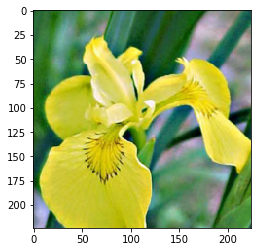

In [18]:
# Control of process_image function
imshow(img);

In [13]:
'''
# Process image with thumbnail - complicated version - output numpy ndarray
def process_image(image_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch       
    model, returns an Numpy array
    '''
    # Open the image
    from PIL import Image
    img = Image.open(image_path)
    # Resize
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop 
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # Normalize
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # Move color channels to first dimension as expected by PyTorch
    img = img.transpose((2, 0, 1))
    
    return img
'''

In [14]:
'''img.shape'''

torch.Size([3, 224, 224])

In [15]:
'''def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax
'''

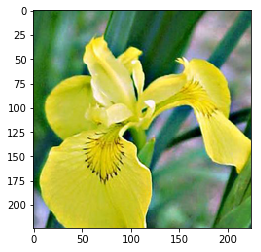

In [16]:
'''image_path = os.path.join(data_dir, 'test', '15', 'image_06351.jpg')
img = process_image(image_path)
imshow(img)
'''

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [82]:
# Trial and error
'''
def predict(image_path, model_conv, top_num=5):
    # Process image
    img = process_image(image_path)
    
    # Numpy -> Tensor
    image_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Add batch of size 1 to image
    model_input = image_tensor.unsqueeze(0)
    
    # Probs
    model_input = model_input.to(device)
    probs = torch.exp(model_conv.forward(model_input))
    
    # Top probs
    top_probs, top_labs = probs.topk(top_num)
    top_probs = top_probs.detach().numpy().tolist()[0] 
    top_labs = top_labs.detach().numpy().tolist()[0]
    
    # Convert indices to classes
    idx_to_class = {val: key for key, val in    
                                      model_conv.class_to_idx.items()}
    top_labels = [idx_to_class[lab] for lab in top_labs]
    top_flowers = [cat_to_name[idx_to_class[lab]] for lab in top_labs]
    return top_probs, top_labels, top_flowers
'''

In [81]:
'''
image_path = os.path.join(data_dir, 'test', '15', 'image_06351.jpg')
predict(image_path, model_conv)
'''

TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [68]:
# Trial and error
'''
def plot_solution(image_path, model_conv):
    # Set up plot
    index = 15
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    # Set up title
    flower_num = image_path.split('/')[1]
    title_ = cat_to_name[str(index)]
    # Plot flower
    img = process_image(image_path)
    imshow(img, ax, title = title_);
    # Make prediction
    probs, labs, flowers = predict(image_path, model_conv) 
    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=flowers, color=sns.color_palette()[0]);
    plt.show()
'''

TypeError: expected np.ndarray (got Tensor)

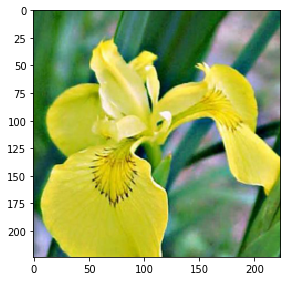

In [69]:
'''
image_path = os.path.join(data_dir, 'test', '15', 'image_06351.jpg')
plot_solution(image_path, model_conv)
'''

In [111]:
'''img_path = os.path.join(test_dir,'100','image_07926.jpg')
val1, val2 = predict(img_path, model_conv)
print(val1)
print(val2)
#predict(img_path, model_conv, topk=5)'''

"img_path = os.path.join(test_dir,'100','image_07926.jpg')\nval1, val2 = predict(img_path, model_conv)\nprint(val1)\nprint(val2)\n#predict(img_path, model_conv, topk=5)"

In [19]:
# Predict 
''' Predict the class (or classes) of an image using a trained deep learning model.
'''

model_conv.class_to_idx =train_data.class_to_idx

ctx = model_conv.class_to_idx


def predict(image_path, model_conv, topk=5):   
    model_conv.to('cuda:0')
    img_torch = process_image(image_path)
    img_torch = img_torch.unsqueeze_(0)
    img_torch = img_torch.float()
    
    with torch.no_grad():
        output = model_conv.forward(img_torch.cuda())
        
    probability = F.softmax(output.data,dim=1)
    
    return probability.topk(topk)
    
    # TODO: Implement the code to predict the class from an image file

In [20]:
img_path = os.path.join(test_dir,'15','image_06351.jpg')
val1, val2 = predict(img_path, model_conv)
print(val1)
print(val2)
#predict(img_path, model_conv, topk=5)

tensor([[ 0.2231,  0.1257,  0.0955,  0.0755,  0.0611]], device='cuda:0')
tensor([[  9,  80,  55,  12,  54]], device='cuda:0')


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [21]:
# TODO: Display an image along with the top 5 classes
def check_sanity():
    plt.rcParams["figure.figsize"] = (10,5)
    plt.subplot(211)
    
    index = 1
    path = os.path.join(test_dir,'1','image_06743.jpg')

    probabilities = predict(path, model_conv)
    image = process_image(path)
    probabilities = probabilities
    

    axs = imshow(image, ax = plt)
    axs.axis('off')
    axs.title(cat_to_name[str(index)])
    axs.show()
    
    
    a = np.array(probabilities[0][0])
    b = [cat_to_name[str(index+1)] for index in np.array(probabilities[1][0])]
    
    
    N=float(len(b))
    fig,ax = plt.subplots(figsize=(8,3))
    width = 0.8
    tickLocations = np.arange(N)
    ax.bar(tickLocations, a, width, linewidth=4.0, align = 'center')
    ax.set_xticks(ticks = tickLocations)
    ax.set_xticklabels(b, rotation='30')
    ax.set_xlim(min(tickLocations)-0.6,max(tickLocations)+0.6)
    ax.set_yticks([0.2,0.4,0.6,0.8,1,1.2])
    ax.set_ylim((0,1))
    ax.yaxis.grid(True)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    plt.show()

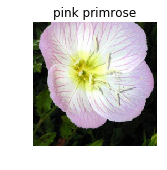

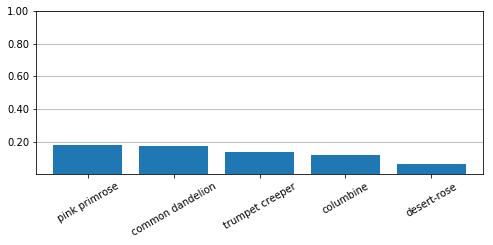

In [22]:
check_sanity()